In [1]:
import os
import numpy as np
import torch
import torchvision.transforms as tf
from torch.utils.data import Dataset
import cv2
from torch.utils import data
import matplotlib.pyplot as plt
import segmentation_models_pytorch
from PIL import Image

In [2]:
# Create custom dataset class
class SegNetDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = os.listdir(os.path.join(root_dir, 'color-input'))
        self.depths = os.listdir(os.path.join(root_dir, 'depth-input'))
        self.masks  = os.listdir(os.path.join(root_dir, 'label'))


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path    = os.path.join(self.root_dir, 'color-input', self.images[idx])
        depth_path  = os.path.join(self.root_dir, 'depth-input', self.depths[idx])
        mask_path   = os.path.join(self.root_dir, 'label', self.masks[idx])
        image = cv2.imread(img_path)
        depth = cv2.imread(depth_path)
        mask  = cv2.imread(mask_path)
        gt_mask = self.convert_gray_to_rgb(mask)

        # Convert to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        gt_mask = cv2.cvtColor(gt_mask, cv2.COLOR_BGR2RGB)

        # convert to PIL image
        depth = Image.fromarray(depth)
        gt_mask = Image.fromarray(gt_mask)
        image = Image.fromarray(image)
        mask = Image.fromarray(mask)
        
        if self.transform:
            depth = self.transform(depth)
            image = self.transform(image)
            mask = self.transform(mask)
            gt_mask = self.transform(gt_mask)
        return image, mask, depth, gt_mask
        
    def convert_gray_to_rgb(self, image):
        # Convert 255 to mask
        r_mask = g_mask = b_mask = np.zeros((image.shape[0], image.shape[1], 3))

        r_mask[np.where((image == [0, 0, 0]).all(axis = 2))] = [0,0,255]
        g_mask[np.where((image == [128, 128, 128]).all(axis = 2))] = [0,255,0]
        b_mask[np.where((image == [255, 255, 255]).all(axis = 2))] = [255,0,0]
        
        # Make rgb image from mask 
        bgr_image = np.zeros((image.shape[0], image.shape[1], 3))
        bgr_image = b_mask + g_mask + r_mask
        return bgr_image.astype(np.uint8)

        
transforms = tf.Compose([
    tf.ToTensor(),
    # tf.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

dataset = SegNetDataset(root_dir='_data', transform=transforms)

# Split dataset into train and test
train_data, test_data = data.random_split(dataset, [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)])

# Create dataloaders
train_loader = data.DataLoader(train_data, batch_size=4, shuffle=True,  num_workers=1)
test_loader  = data.DataLoader(test_data,  batch_size=4, shuffle=False, num_workers=1)

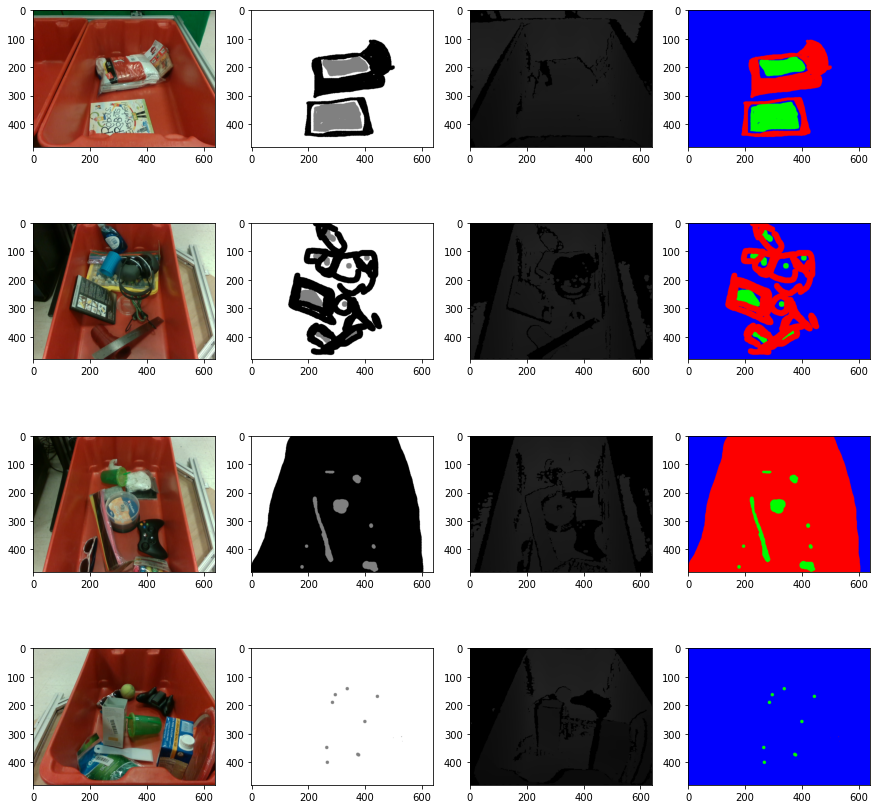

In [3]:
# Load a test batch
images, masks, depths, gt_mask = next(iter(test_loader))

# Plot a test batch
fig, ax = plt.subplots(4, 4, figsize=(15, 15))
for i in range(4):
    ax[i, 0].imshow(images[i].permute(1, 2, 0))
    ax[i, 1].imshow(masks[i].permute(1, 2, 0))
    ax[i, 2].imshow(depths[i].permute(1, 2, 0))
    ax[i, 3].imshow(gt_mask[i].permute(1, 2, 0))
plt.show()

In [4]:
# Find GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Get ReResNet101 pretrained model to use as encoder
model = segmentation_models_pytorch.Unet(encoder_name='resnet101', encoder_weights='imagenet', classes=3, activation=None, in_channels=3)

# print(model)
model.encoder.train = False
model.decoder.train = False
model.segmentation_head.train = True
# Print model children
for name, child in model.named_children():
    print(name)

# Move model to GPU
model.to(device)

/home/claus/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


encoder
decoder
segmentation_head


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

# Train model

In [5]:
# Train model
from matplotlib import pyplot as plt
from IPython.display import clear_output

# Train model

# Define loss function
# criterion = torch.nn.CrossEntropyLoss()

# Weighted cross entropy loss
pos_wt = torch.tensor ([1, 1, 1]).to(device)
# weights = torch.tensor([1, 1, 1]).to(device)
criterion = torch.nn.BCEWithLogitsLoss(weight=pos_wt.unsqueeze(-1).unsqueeze (-1))

# binary_cross_entropy_with_logits

# criterion = torch.nn.CrossEntropyLoss(weight=weights)
# criterion = torch.nn.functional.binary_cross_entropy_with_logits()


# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# fig, ax = plt.subplots(1, 2, figsize=(15, 15))
plot = True

plt.ion()
# fig, ax = plt.subplots(1, 2, figsize=(15, 15))
plt.figure()


def max_rgb_filter(pil_image):
    image = np.array(pil_image)
    # split the image into its BGR components
    (b, g, r) = cv2.split(image)
    # find the maximum pixel intensity values for each
    # (x, y)-coordinate,, then set all pixel values less
    # than M to zero
    max = np.maximum(np.maximum(r, g), b)
    r[r < max] = 0
    g[g < max] = 0
    b[b < max] = 0
    # merge the channels back together and return the image
    bgr = cv2.merge([b, g, r])
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    return Image.fromarray(rgb)

# Train model
for epoch in range(10):
    for i, (images, masks, depths, gt_mask) in enumerate(train_loader):
        images = images.to(device)
        masks = masks.to(device)
        depths = depths.to(device)
        gt_mask = gt_mask.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, gt_mask)
        loss.backward()
        optimizer.step()

        # convert to PIL image
        outputs = tf.ToPILImage()(outputs[0].cpu())
        outputs = max_rgb_filter(outputs)
        gt_mask = tf.ToPILImage()(gt_mask[0].cpu())
        if (i+1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, 10, i+1, len(train_loader), loss.item()))
            plt.imshow(outputs) # [0].permute(1, 2, 0).cpu().detach().numpy().astype('uint8')
            plt.show()
            plt.imshow(gt_mask) # [0].permute(1, 2, 0).cpu().detach().numpy().astype('uint8')
            plt.show()
            clear_output(wait=True)


            # print("type(outputs): ", type(outputs))
            # print("outputs.shape: ", outputs.shape)
            # print("type(gt_mask): ", type(gt_mask))
            # print("gt_mask.shape: ", gt_mask.shape)

# # Test model
# with torch.no_grad():
#     correct = 0
#     total = 0
#     for images, masks, depths, gt_mask in test_loader:
#         images = images.to(device)
#         masks = masks.to(device)
#         depths = depths.to(device)
#         # gt_mask = gt_mask.to(device)
#         outputs = model(images)
#         predicted = max_rgb_filter(outputs[0].permute(1, 2, 0).detach().numpy())
#         # _, predicted = torch.max(outputs.data, 1, dim=0)
#         total += gt_mask.size(0)
#         print("predicted.shape: ", predicted.shape)
#         print("gt_mask.shape: ", gt_mask.shape)
#         correct += (predicted == gt_mask).sum().item()
#     print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))



KeyboardInterrupt: 